# GStreamer Frame Capture with Python

This notebook demonstrates how to capture frames using GStreamer in Python. It's initially designed to work on Windows but includes notes for transferring to a Qualcomm QCM6490-based device.

In [9]:
!pip install "qai-hub-models[yolov11-det]"
import qai_hub_models.models.yolov11_det
dir(qai_hub_models.models.yolov11_det)

['App',
 'MODEL_ID',
 'Model',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 'model']

## 1. Import Required Libraries

First, we need to import the necessary libraries for GStreamer integration with Python.

In [10]:
import os
import sys
import numpy as np
import time
from threading import Thread

# For visualization
import cv2
import matplotlib.pyplot as plt
# %matplotlib inline

# Setup GStreamer import path for Windows
if os.name == "nt":
    os.environ["GST_PLUGIN_PATH"] = r"C:\gstreamer\1.0\mingw_x86_64\lib\gstreamer-1.0"

try:
    import gi
    gi.require_version('Gst', '1.0')
    from gi.repository import Gst, GLib
    print("GStreamer libraries imported successfully")
except ImportError:
    print("Failed to import GStreamer libraries. Make sure GStreamer is properly installed.")
    print("On Windows, you need to install GStreamer and set the correct PATH variables.")
    print("On Qualcomm QCM6490, ensure appropriate GStreamer packages are installed.")

GStreamer libraries imported successfully


## 2. Setup GStreamer Environment

Initialize the GStreamer environment. This needs to be done before creating any GStreamer elements.

In [11]:
# Initialize GStreamer
Gst.init(None)
print(f"GStreamer version: {Gst.version_string()}")

# Check available plugins
plugin_list = []
registry = Gst.Registry.get()
for plugin in registry.get_plugin_list():
    plugin_list.append(plugin.get_name())

print(f"Total plugins available: {len(plugin_list)}")
print("Sample of available plugins:")
for plugin in sorted(plugin_list)[:10]:  # Just show the first 10
    print(f"- {plugin}")

GStreamer version: GStreamer 1.16.3
Total plugins available: 275
Sample of available plugins:
- 1394
- a52dec
- aasink
- accurip
- adder
- adpcmdec
- adpcmenc
- aiff
- alaw
- alpha


## 3. Create a Simple Pipeline

Now we'll create a GStreamer pipeline that captures video from a camera. This example uses DirectShow on Windows.

**Note for Qualcomm QCM6490**: When transferring to the Qualcomm device, you'll likely need to replace the source element with an appropriate one for that platform, such as `v4l2src` for Video4Linux2 sources.

In [12]:
def create_pipeline(camera_id=0):
    # For Windows: Use DirectShow source
    # Note: On Qualcomm QCM6490, use qtiqmmfsrc for CSI cameras
    if sys.platform == 'win32':
        source_element = "dshowvideosrc"
        # Alternative: ksvideosrc for Windows
        # source_element = "ksvideosrc"
        pipeline_str = (
            f"{source_element} ! "
            "videoconvert ! "
            "video/x-raw,format=RGB ! "
            "appsink name=sink emit-signals=true"
        )
    else:
        # For Qualcomm QCM6490 devices, use qtiqmmfsrc for CSI cameras
        # This works better than v4l2src for Qualcomm hardware
        pipeline_str = (
            f"qtiqmmfsrc camera={camera_id} ! "
            "video/x-raw,format=NV12,width=640,height=480,framerate=15/1 ! "
            "videoconvert ! "
            "video/x-raw,format=RGB ! "
            "appsink name=sink emit-signals=true"
        )
    
    print(f"Creating pipeline: {pipeline_str}")
    
    try:
        pipeline = Gst.parse_launch(pipeline_str)
        return pipeline
    except GLib.Error as e:
        print(f"Error creating pipeline: {e}")
        return None

## 4. Capture Single Frames

Next, we'll implement a callback function to intercept frames from the GStreamer pipeline using the appsink element.

In [13]:
class FrameCapture:
    def __init__(self, camera_id=0):
        self.pipeline = create_pipeline(camera_id)
        if not self.pipeline:
            raise RuntimeError("Failed to create GStreamer pipeline")
        
        self.loop = GLib.MainLoop()
        self.thread = Thread(target=self.run_loop)
        self.running = False
        self.latest_frame = None
        
        # Get sink element from pipeline
        self.sink = self.pipeline.get_by_name("sink")
        if not self.sink:
            raise RuntimeError("Could not find appsink in the pipeline")
        
        # Connect to the "new-sample" signal
        self.sink.connect("new-sample", self.on_new_sample)
    
    def run_loop(self):
        self.loop.run()
    
    def start(self):
        # Start the pipeline
        ret = self.pipeline.set_state(Gst.State.PLAYING)
        if ret == Gst.StateChangeReturn.FAILURE:
            raise RuntimeError("Failed to set pipeline to playing state")
        
        self.running = True
        self.thread.start()
        print("Pipeline started")
    
    def stop(self):
        if self.running:
            self.loop.quit()
            self.pipeline.set_state(Gst.State.NULL)
            self.thread.join()
            self.running = False
            print("Pipeline stopped")
    
    def on_new_sample(self, sink):
        # This function will be called when a new frame is available
        sample = sink.emit("pull-sample")
        if not sample:
            return Gst.FlowReturn.ERROR
        
        # Get the buffer from the sample
        buffer = sample.get_buffer()
        caps = sample.get_caps()
        
        # Get buffer data
        success, map_info = buffer.map(Gst.MapFlags.READ)
        if not success:
            buffer.unmap(map_info)
            return Gst.FlowReturn.ERROR
        
        # Get dimensions from caps
        structure = caps.get_structure(0)
        width = structure.get_value("width")
        height = structure.get_value("height")
        
        # Copy buffer data to numpy array
        self.latest_frame = np.ndarray(
            shape=(height, width, 3),
            dtype=np.uint8,
            buffer=map_info.data
        ).copy()  # Make a copy to avoid issues after unmapping
        
        # Clean up
        buffer.unmap(map_info)
        
        return Gst.FlowReturn.OK
    
    def get_frame(self):
        """Get the latest captured frame"""
        return self.latest_frame

## 5. Capture and Display a Frame

Now let's use our `FrameCapture` class to capture and display frames from the camera.

Creating pipeline: qtiqmmfsrc camera=0 ! video/x-raw,format=NV12,width=640,height=480,framerate=15/1 ! videoconvert ! video/x-raw,format=RGB ! appsink name=sink emit-signals=true


Pipeline started
Waiting for frames...


gbm_create_device(192): Info: backend name is: msm_drm


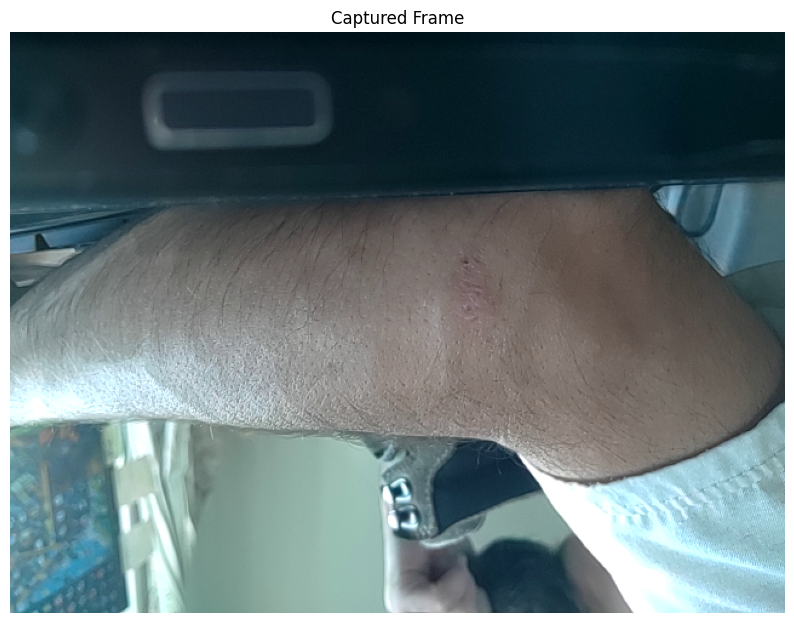

Pipeline stopped


In [14]:
def display_frame(frame):
    if frame is not None:
        plt.figure(figsize=(10, 8))
        plt.imshow(frame)
        plt.axis('off')
        plt.title("Captured Frame")
        plt.show()
    else:
        print("No frame available")

try:
    # Create and start the frame capture
    capture = FrameCapture()
    capture.start()
    
    # Wait a bit for frames to start arriving
    print("Waiting for frames...")
    time.sleep(3)
    
    # Get and display a frame
    frame = capture.get_frame()
    display_frame(frame)
    
    # Clean up
    capture.stop()
    
except Exception as e:
    print(f"Error: {e}")
    
    # Troubleshooting tips
    print("\nTroubleshooting Tips:")
    print("1. Make sure your camera is connected and not used by another application")
    print("2. On Windows, check if your camera works with other applications")
    print("3. Try different source elements (ksvideosrc, dshowvideosrc)")
    print("4. For Qualcomm devices, check that the correct camera device is specified")

In [15]:
def create_qualcomm_pipeline_test(camera_id=0):
    """
    Create a GStreamer pipeline specifically for Qualcomm QCM6490 cameras
    """
    # Try the Qualcomm qtiqmmfsrc first
    pipeline_str = (
        f"qtiqmmfsrc camera={camera_id} ! "
        "video/x-raw,format=NV12,width=640,height=480,framerate=15/1 ! "
        "videoconvert ! "
        "video/x-raw,format=RGB ! "
        "appsink name=sink emit-signals=true"
    )
    
    print(f"Creating Qualcomm pipeline: {pipeline_str}")
    
    try:
        pipeline = Gst.parse_launch(pipeline_str)
        return pipeline
    except GLib.Error as e:
        print(f"Error creating Qualcomm pipeline: {e}")
        
        # Fallback: try with a specific v4l2 device
        fallback_pipeline_str = (
            "v4l2src device=/dev/video0 ! "
            "videoconvert ! "
            "video/x-raw,format=RGB,width=640,height=480 ! "
            "appsink name=sink emit-signals=true"
        )
        
        print(f"Trying fallback pipeline: {fallback_pipeline_str}")
        try:
            pipeline = Gst.parse_launch(fallback_pipeline_str)
            return pipeline
        except GLib.Error as e2:
            print(f"Error creating fallback pipeline: {e2}")
            return None

# Test the Qualcomm-specific pipeline
test_pipeline = create_qualcomm_pipeline_test(camera_id=0)
if test_pipeline:
    print("Pipeline created successfully!")
    
    # Try to set it to READY state first
    ret = test_pipeline.set_state(Gst.State.READY)
    if ret == Gst.StateChangeReturn.FAILURE:
        print("Failed to set pipeline to READY state")
    else:
        print("Pipeline set to READY state successfully")
        
        # Try to set it to PLAYING state
        ret = test_pipeline.set_state(Gst.State.PLAYING)
        if ret == Gst.StateChangeReturn.FAILURE:
            print("Failed to set pipeline to PLAYING state")
        else:
            print("Pipeline set to PLAYING state successfully!")
            
        # Clean up
        test_pipeline.set_state(Gst.State.NULL)
        print("Pipeline stopped and cleaned up")
else:
    print("Failed to create any working pipeline")

Creating Qualcomm pipeline: qtiqmmfsrc camera=0 ! video/x-raw,format=NV12,width=640,height=480,framerate=15/1 ! videoconvert ! video/x-raw,format=RGB ! appsink name=sink emit-signals=true
Pipeline created successfully!
Pipeline set to READY state successfully
Pipeline set to PLAYING state successfully!


gbm_create_device(192): Info: backend name is: msm_drm


Pipeline stopped and cleaned up


Testing FrameCapture with Qualcomm camera...
Creating pipeline: qtiqmmfsrc camera=0 ! video/x-raw,format=NV12,width=640,height=480,framerate=15/1 ! videoconvert ! video/x-raw,format=RGB ! appsink name=sink emit-signals=true
Pipeline started
Waiting for frames...


gbm_create_device(192): Info: backend name is: msm_drm


Successfully captured frame with shape: (480, 640, 3)


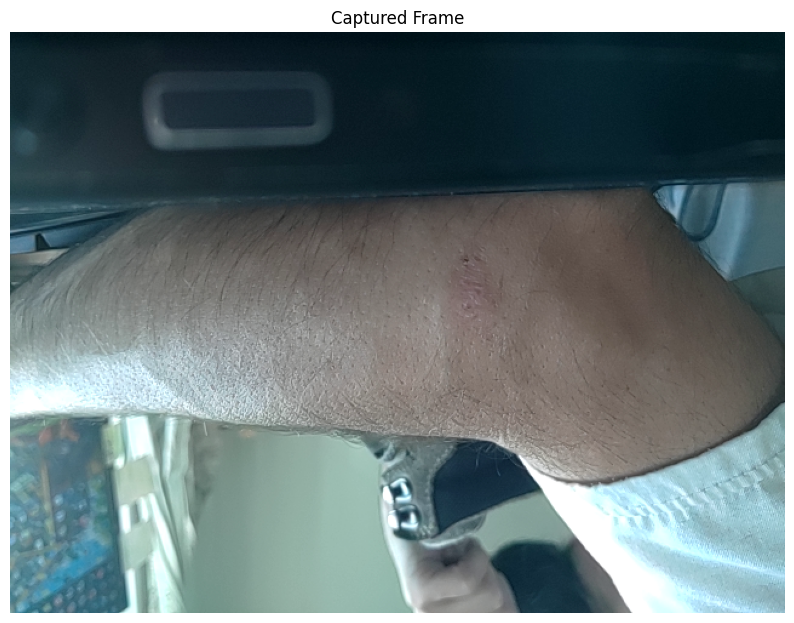

Pipeline stopped
Camera test completed successfully!


In [16]:
# Test the updated FrameCapture class with Qualcomm camera
try:
    print("Testing FrameCapture with Qualcomm camera...")
    
    # Create and start the frame capture with camera 0 (CSI0)
    capture = FrameCapture(camera_id=0)
    capture.start()
    
    # Wait a bit for frames to start arriving
    print("Waiting for frames...")
    time.sleep(3)
    
    # Get and display a frame
    frame = capture.get_frame()
    if frame is not None:
        print(f"Successfully captured frame with shape: {frame.shape}")
        display_frame(frame)
    else:
        print("No frame available yet")
    
    # Clean up
    capture.stop()
    print("Camera test completed successfully!")
    
except Exception as e:
    print(f"Error during camera test: {e}")
    import traceback
    traceback.print_exc()

Testing FrameCapture with camera=1 (CSI1)...
Creating pipeline: qtiqmmfsrc camera=1 ! video/x-raw,format=NV12,width=640,height=480,framerate=15/1 ! videoconvert ! video/x-raw,format=RGB ! appsink name=sink emit-signals=true
Pipeline started
Waiting for frames...


gbm_create_device(192): Info: backend name is: msm_drm


Successfully captured frame from CSI1 with shape: (480, 640, 3)


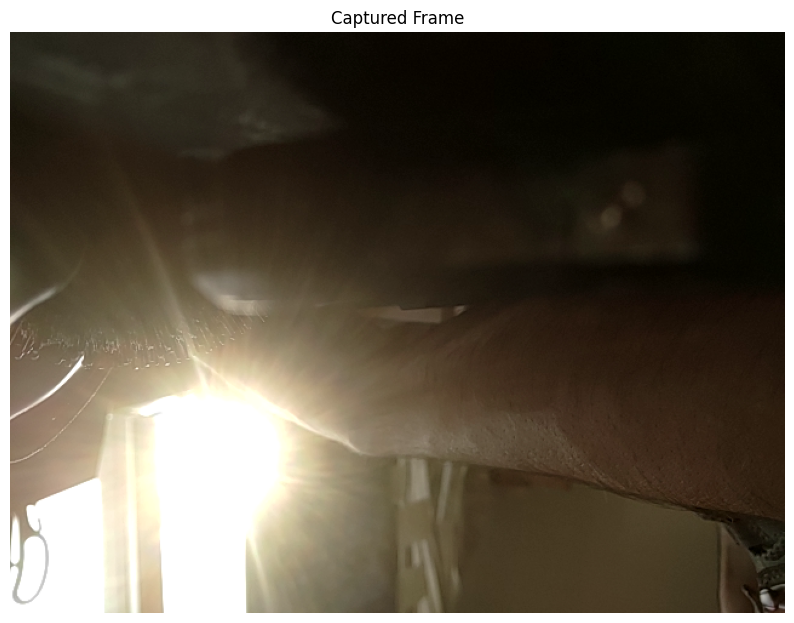

Pipeline stopped
Camera=1 test completed!


In [17]:
# Test camera=1 (CSI1)
try:
    print("Testing FrameCapture with camera=1 (CSI1)...")
    
    # Create and start the frame capture with camera 1 (CSI1)
    capture = FrameCapture(camera_id=1)
    capture.start()
    
    # Wait a bit for frames to start arriving
    print("Waiting for frames...")
    time.sleep(3)
    
    # Get and display a frame
    frame = capture.get_frame()
    if frame is not None:
        print(f"Successfully captured frame from CSI1 with shape: {frame.shape}")
        display_frame(frame)
    else:
        print("No frame available from CSI1")
    
    # Clean up
    capture.stop()
    print("Camera=1 test completed!")
    
except Exception as e:
    print(f"Error during camera=1 test: {e}")
    import traceback
    traceback.print_exc()

## 6. Continuous Frame Capture

For continuous capture, we can modify our approach to grab multiple frames.

Creating pipeline: qtiqmmfsrc camera=0 ! video/x-raw,format=NV12,width=640,height=480,framerate=15/1 ! videoconvert ! video/x-raw,format=RGB ! appsink name=sink emit-signals=true
Pipeline started
Capturing frames for 10 seconds...


gbm_create_device(192): Info: backend name is: msm_drm


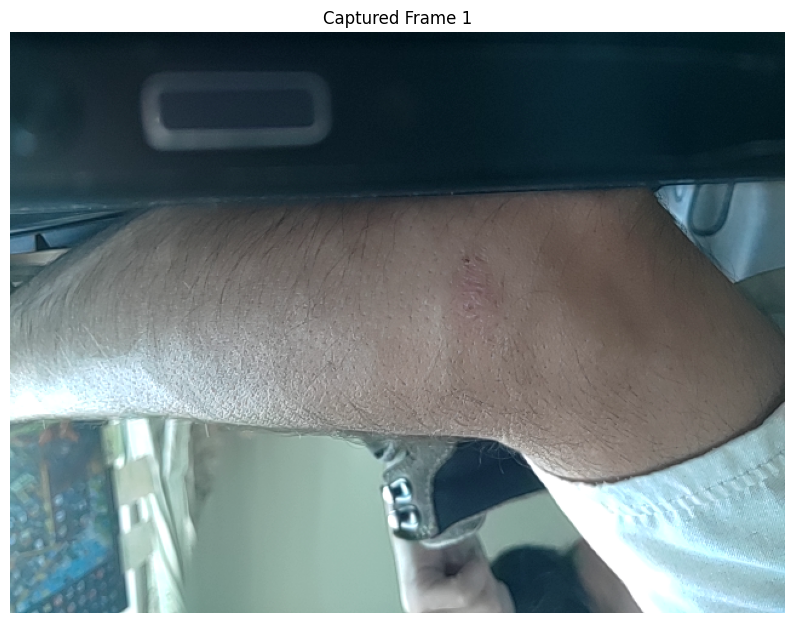

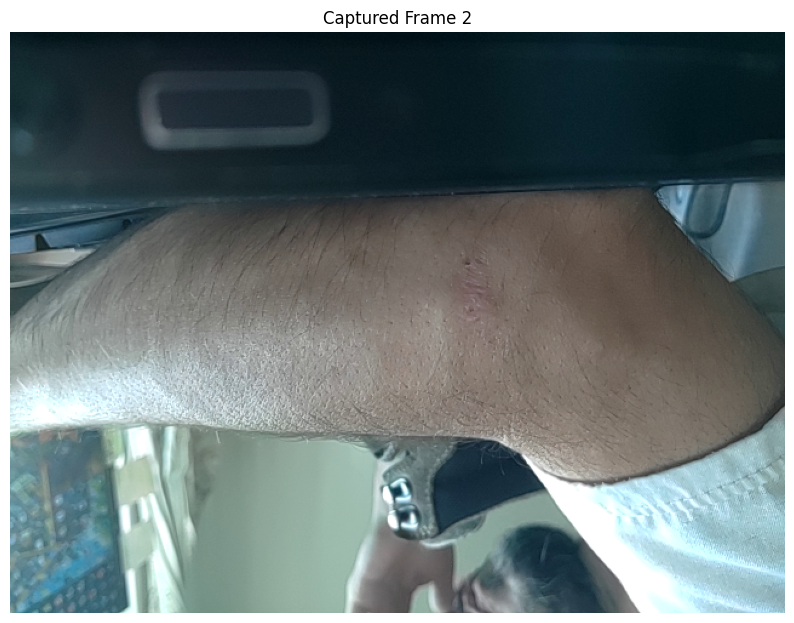

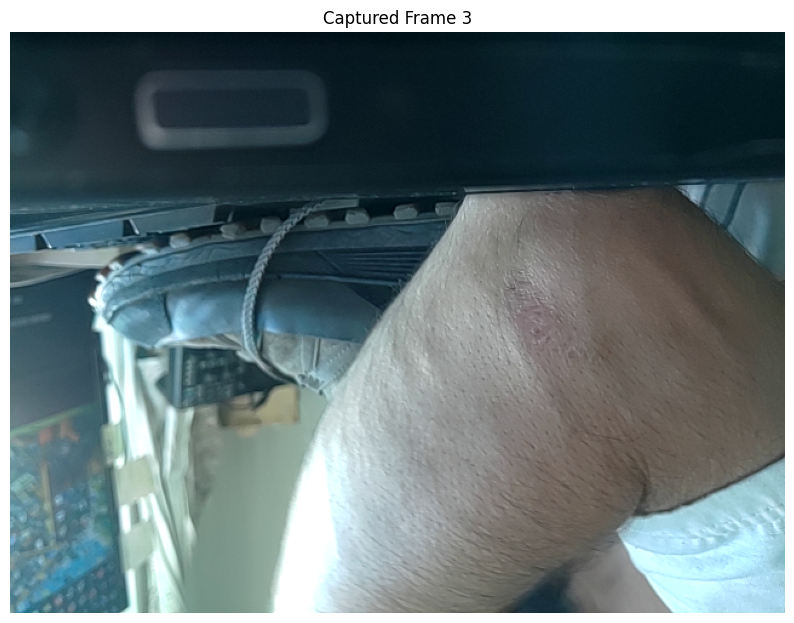

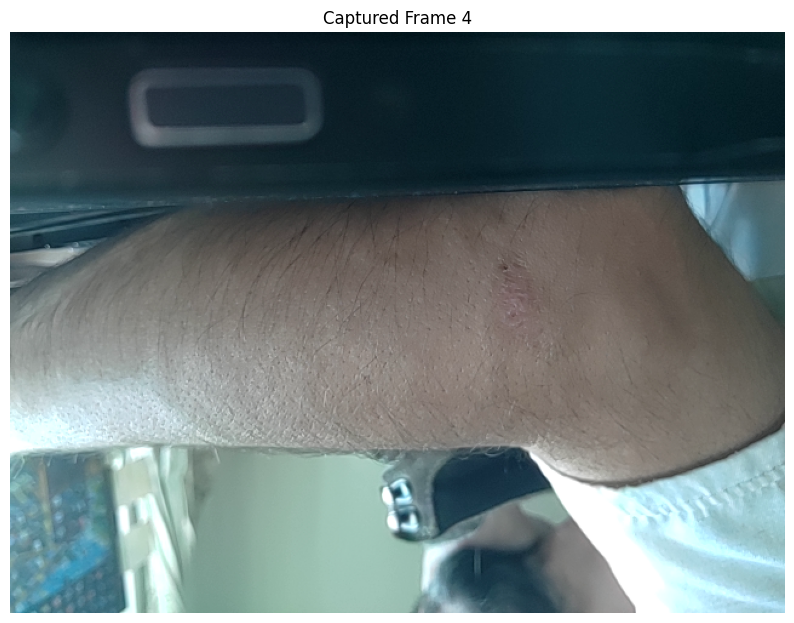

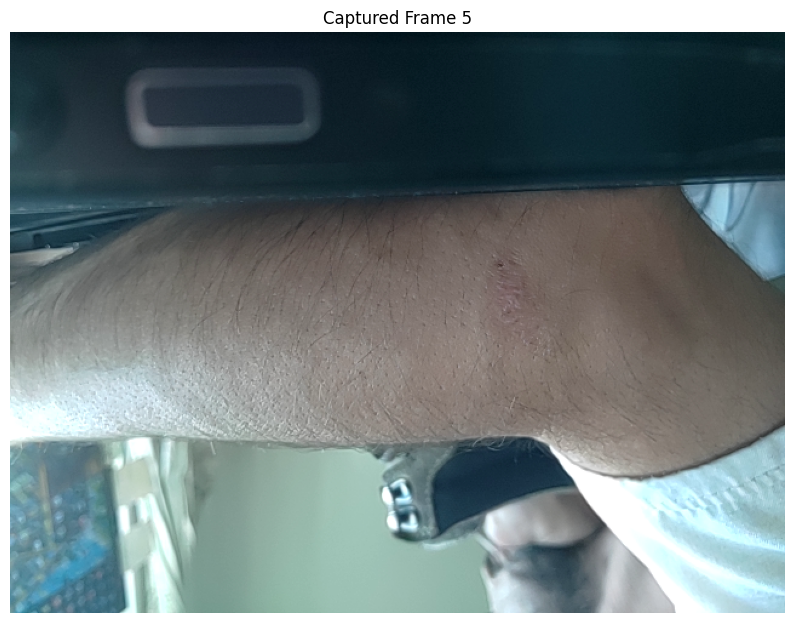

Pipeline stopped


In [18]:
try:
    # Create and start the frame capture
    capture = FrameCapture()
    capture.start()
    
    # Capture a few frames
    print("Capturing frames for 10 seconds...")
    
    # Show 5 frames with 2 second intervals
    for i in range(5):
        time.sleep(2)
        frame = capture.get_frame()
        
        if frame is not None:
            plt.figure(figsize=(10, 8))
            plt.imshow(frame)
            plt.axis('off')
            plt.title(f"Captured Frame {i+1}")
            plt.show()
        else:
            print(f"No frame available for frame {i+1}")
    
    # Clean up
    capture.stop()
    
except Exception as e:
    print(f"Error: {e}")

## 7. Clean Up Resources

Always make sure to clean up GStreamer resources properly.

In [19]:
# This function is already called in our FrameCapture class,
# but here's a standalone example of proper cleanup

def cleanup_gstreamer(pipeline):
    if pipeline:
        # Stop the pipeline
        pipeline.set_state(Gst.State.NULL)
        print("Pipeline released")

# Example usage (not executed, just for reference)
# cleanup_gstreamer(pipeline)

## 8. Cross-Platform Considerations

When transferring this code to a Qualcomm QCM6490-based device, consider the following:

1. **Source Element**: Replace `dshowvideosrc` with `v4l2src` (Video4Linux2) for Linux-based platforms.

2. **Device Selection**: For V4L2, specify the device path with `device=/dev/video0` (or appropriate device number).

3. **Hardware Acceleration**: Qualcomm devices often support hardware acceleration. Consider using elements like:
   - `qtiqmmfsrc` - Qualcomm FastCV camera source (if available)
   - Hardware-accelerated elements for encoding/decoding

4. **Pipeline Modifications**: For Qualcomm devices, a more optimized pipeline might look like:

In [20]:
# Example pipeline for Qualcomm QCM6490 (NOT for execution on Windows)
# This is just a reference for when you transfer to the Qualcomm device

def create_qualcomm_pipeline(camera_id=0, output_file=None):
    """
    Create a GStreamer pipeline optimized for Qualcomm QCM6490.
    
    This is based on the provided GStreamer command:
    gst-launch-1.0 -e qtiqmmfsrc camera=0 \
    ! video/x-raw,format=NV12,width=1920,height=1080,framerate=30/1 \
    ! qtic2venc ! h264parse ! mp4mux ! queue \
    ! filesink location=/home/particle/video_snapshot.mp4 \
    --gst-debug=qtiqmmfsrc:LOG
    
    Parameters:
    - camera_id: 0 for CSI0, 1 for CSI1
    - output_file: Optional file path to save the video
    """
    # For frame-by-frame analysis, we'll modify the pipeline to use appsink
    # instead of saving to file
    pipeline_str = (
        f"qtiqmmfsrc camera={camera_id} ! "
        "video/x-raw,format=NV12,width=1920,height=1080,framerate=30/1 ! "
        "videoconvert ! "
        "video/x-raw,format=RGB ! "
        "appsink name=sink emit-signals=true"
    )
    
    # Alternative pipeline that saves to file (similar to the original command)
    # Only used if output_file is specified
    if output_file:
        pipeline_str = (
            f"qtiqmmfsrc camera={camera_id} ! "
            "video/x-raw,format=NV12,width=1920,height=1080,framerate=30/1 ! "
            "qtic2venc ! h264parse ! mp4mux ! queue ! "
            f"filesink location={output_file}"
        )
    
    print(f"Qualcomm pipeline: {pipeline_str}")
    
    try:
        pipeline = Gst.parse_launch(pipeline_str)
        return pipeline
    except GLib.Error as e:
        print(f"Error creating pipeline: {e}")
        return None

# Note: This code should not be executed on Windows
# It's only a reference for when you transfer to the Qualcomm device

## 9. Debugging Tips

Here are some tips for debugging GStreamer issues, which will be useful when transferring to the Qualcomm device:

In [21]:
def print_device_capabilities(device_path="/dev/video0"):
    """
    Print capabilities of a video device (for Linux/Qualcomm)
    This won't work on Windows - it's for reference when you transfer
    to the Qualcomm device
    """
    print(f"To check device capabilities on Qualcomm device, run:")
    print(f"v4l2-ctl --device={device_path} --list-formats-ext")
    
    # Example of setting GStreamer debug environment variables
    print("\nTo enable GStreamer debugging on the Qualcomm device, set:")
    print("export GST_DEBUG=3")  # Adjust level (1-9) as needed
    print("export GST_DEBUG_FILE=gstreamer_log.txt")  # Optional log file

# For Windows: Get list of DirectShow devices
def list_dshow_devices():
    """List available DirectShow devices on Windows"""
    print("To list DirectShow devices on Windows, run this in a terminal:")
    print("gst-device-monitor-1.0.exe Video/Source")

# Call the Windows function as we're currently on Windows
if sys.platform == "win32":
    list_dshow_devices()
else:
    print_device_capabilities()

To check device capabilities on Qualcomm device, run:
v4l2-ctl --device=/dev/video0 --list-formats-ext

To enable GStreamer debugging on the Qualcomm device, set:
export GST_DEBUG=3
export GST_DEBUG_FILE=gstreamer_log.txt


## 10. Conclusion

This notebook has demonstrated how to:
1. Set up GStreamer with Python
2. Create a video capture pipeline
3. Extract frames from the pipeline
4. Convert GStreamer buffers to NumPy arrays
5. Display the captured frames

When transferring to the Qualcomm QCM6490 device, remember to modify the source element and possibly other parts of the pipeline to leverage the device's hardware capabilities.

## 11. Test Image Processing on Windows

Since we want to develop on Windows before deploying to the Qualcomm device, let's create functionality to process test images instead of using GStreamer on Windows.

Found 3 test images in test_images
Test images already exist
Loaded test image: test_images/sample_1.jpg


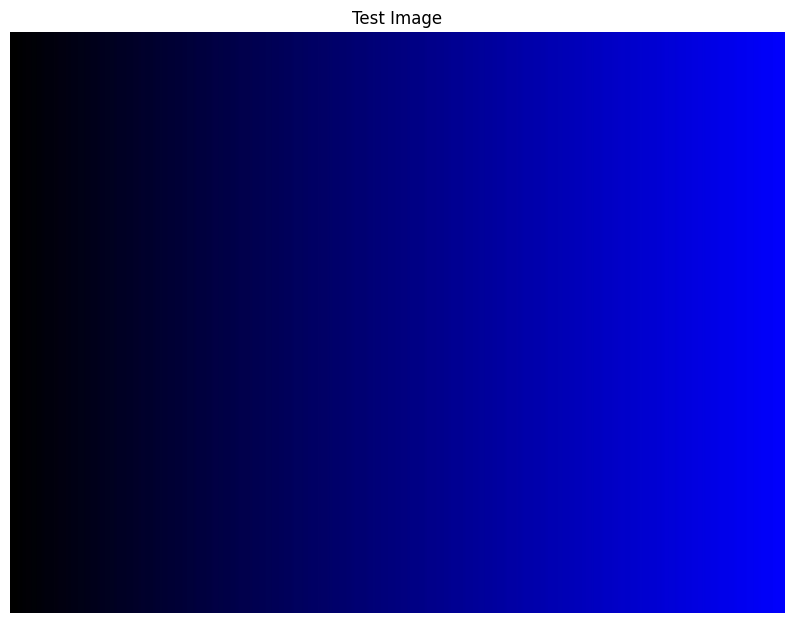

In [22]:
import os
import glob
from pathlib import Path

class TestImageProcessor:
    """Class for processing test images on Windows before deploying to Qualcomm"""
    
    def __init__(self, image_dir="test_images", image_pattern="*.jpg"):
        """
        Initialize the test image processor
        
        Args:
            image_dir: Directory containing test images
            image_pattern: Glob pattern for test images
        """
        self.image_dir = image_dir
        self.image_pattern = image_pattern
        self.current_index = 0
        self.images = []
        
        # Create test images directory if it doesn't exist
        os.makedirs(self.image_dir, exist_ok=True)
        
        # Find all test images
        self.refresh_image_list()
        
    def refresh_image_list(self):
        """Refresh the list of available test images"""
        path_pattern = os.path.join(self.image_dir, self.image_pattern)
        self.images = sorted(glob.glob(path_pattern))
        print(f"Found {len(self.images)} test images in {self.image_dir}")
        
    def get_next_frame(self):
        """Get the next test image as a frame"""
        if not self.images:
            print("No test images found")
            return None
        
        # Cycle through available images
        image_path = self.images[self.current_index]
        self.current_index = (self.current_index + 1) % len(self.images)
        
        # Read the image using OpenCV
        frame = cv2.imread(image_path)
        if frame is not None:
            # Convert from BGR to RGB (OpenCV uses BGR by default)
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            print(f"Loaded test image: {image_path}")
        else:
            print(f"Failed to load test image: {image_path}")
            
        return frame
    
    def add_sample_images(self, num_samples=3):
        """Download or create sample test images if none exist"""
        if self.images:
            print("Test images already exist")
            return
            
        print(f"Creating {num_samples} sample test images...")
        
        # Create simple color gradient images as samples
        for i in range(num_samples):
            # Create a gradient image (just as an example)
            width, height = 640, 480
            image = np.zeros((height, width, 3), dtype=np.uint8)
            
            # Create different colored gradients
            if i % 3 == 0:
                # Red gradient
                for y in range(height):
                    for x in range(width):
                        image[y, x, 0] = int(255 * x / width)  # R
            elif i % 3 == 1:
                # Green gradient
                for y in range(height):
                    for x in range(width):
                        image[y, x, 1] = int(255 * y / height)  # G
            else:
                # Blue gradient
                for y in range(height):
                    for x in range(width):
                        image[y, x, 2] = int(255 * (x + y) / (width + height))  # B
            
            # Save the image
            filename = os.path.join(self.image_dir, f"sample_{i+1}.jpg")
            cv2.imwrite(filename, image)
            print(f"Created sample image: {filename}")
            
        # Refresh the image list
        self.refresh_image_list()

# Create and test the image processor
test_processor = TestImageProcessor()
test_processor.add_sample_images()

# Load and display a test image
test_frame = test_processor.get_next_frame()
if test_frame is not None:
    plt.figure(figsize=(10, 8))
    plt.imshow(test_frame)
    plt.title("Test Image")
    plt.axis('off')
    plt.show()

## 12. Object Detection with QAI Hub Models

Now, let's integrate the QAI Hub models (YOLOv11) for object detection. We'll create a detector class that can process frames and identify objects of interest.

QAI Hub models imported successfully
Model loaded successfully with 80 classes
Available animal classes: ['bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe']
Loaded test image: test_images/sample_1.jpg
Detected 0 objects, 0 triggers: []
Detected 0 objects, 0 triggers: []


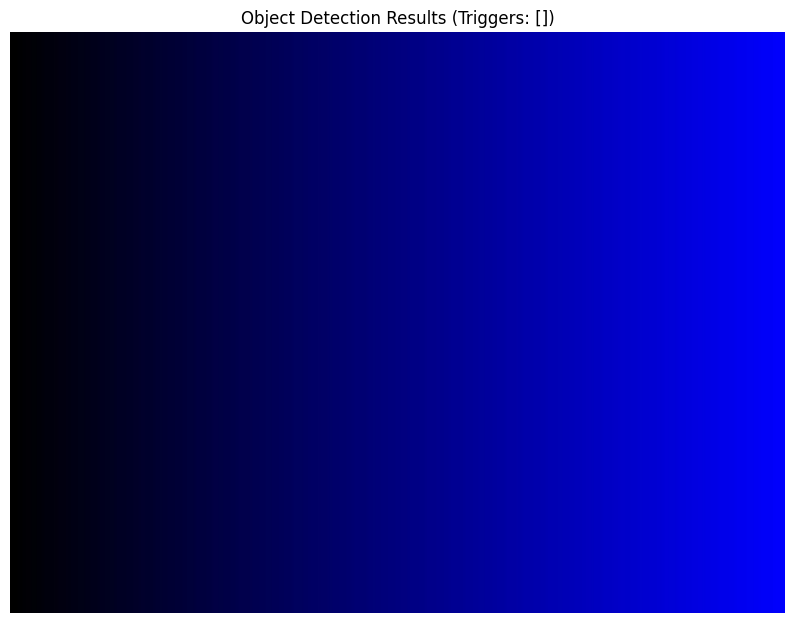

No objects detected


In [28]:
try:
    import qai_hub_models.models.yolov11_det as yolov11_model
    import torch
    import torch.nn.functional as F
    # Create model instance using the Model class from the module
    HAVE_QAI = True
    print("QAI Hub models imported successfully")
except ImportError:
    HAVE_QAI = False
    yolov11_model = None
    print("QAI Hub models not available. Install with: pip install qai-hub-models[yolov11-det]")

class ObjectDetector:
    """Object detector using QAI Hub YOLOv11 model"""
    
    def __init__(self, confidence_threshold=0.5):
        """
        Initialize the object detector
        
        Args:
            confidence_threshold: Minimum confidence level for detections
        """
        self.confidence_threshold = confidence_threshold
        self.model = None
        self.class_names = None
        self.target_classes = ['bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe']  # Animal classes
        self.show_all_detections = True  # Debug flag for showing all detections
        self.show_labels = True  # Debug flag for showing labels on the image
        
        # Load the model if QAI Hub is available
        if HAVE_QAI and yolov11_model:
            try:
                self.model = yolov11_model.Model.from_pretrained()
                self.model.eval()  # Set to evaluation mode
                
                # Get class names dynamically from the model
                if hasattr(self.model, 'model') and hasattr(self.model.model, 'names'):
                    names_dict = self.model.model.names
                    self.class_names = [names_dict[i] for i in sorted(names_dict.keys())]
                    print(f"Model loaded successfully with {len(self.class_names)} classes")
                    print(f"Available animal classes: {[cls for cls in self.target_classes if cls in self.class_names]}")
                else:
                    print("Warning: Could not load class names from model, using COCO defaults")
                    # Fallback to COCO classes if model doesn't have names
                    self.class_names = [
                        'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 
                        'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat',
                        'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack',
                        'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
                        'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
                        'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple',
                        'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 
                        'chair', 'couch', 'potted plant', 'bed', 'dining table', 'toilet', 'tv', 'laptop',
                        'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink',
                        'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'
                    ]
                    
            except Exception as e:
                print(f"Failed to load YOLOv11 model: {e}")
        
    def set_debug_options(self, show_all_detections=None, show_labels=None):
        """Set debug options for detection visualization"""
        if show_all_detections is not None:
            self.show_all_detections = show_all_detections
        if show_labels is not None:
            self.show_labels = show_labels
    
    def preprocess_image(self, frame):
        """Preprocess image for YOLO model"""
        # Convert to RGB if BGR
        if len(frame.shape) == 3 and frame.shape[2] == 3:
            # Assume input is RGB, convert to tensor
            image = frame.astype(np.float32) / 255.0  # Normalize to [0, 1]
        
        # Resize to 640x640
        image_resized = cv2.resize(image, (640, 640))
        
        # Convert to tensor and add batch dimension
        image_tensor = torch.from_numpy(image_resized).permute(2, 0, 1).unsqueeze(0)  # (1, 3, 640, 640)
        
        return image_tensor, (frame.shape[1], frame.shape[0])  # Return original size for scaling
    
    def postprocess_outputs(self, outputs, original_size, conf_threshold=0.5, iou_threshold=0.45):
        """Post-process YOLO outputs to get detections"""
        boxes, scores, class_ids = outputs
        
        # Convert to numpy
        boxes = boxes[0].detach().cpu().numpy()  # (8400, 4)
        scores = scores[0].detach().cpu().numpy()  # (8400,)
        class_ids = class_ids[0].detach().cpu().numpy()  # (8400,)
        
        # Filter by confidence
        mask = scores > conf_threshold
        boxes = boxes[mask]
        scores = scores[mask]
        class_ids = class_ids[mask]
        
        if len(boxes) == 0:
            return []
        
        # Scale boxes back to original image size
        orig_w, orig_h = original_size
        scale_x = orig_w / 640
        scale_y = orig_h / 640
        
        boxes[:, 0] *= scale_x  # x1
        boxes[:, 1] *= scale_y  # y1
        boxes[:, 2] *= scale_x  # x2
        boxes[:, 3] *= scale_y  # y2
        
        # Apply NMS
        indices = self.nms(boxes, scores, iou_threshold)
        
        # Format detections
        detections = []
        for i in indices:
            class_id = int(class_ids[i])
            if class_id < len(self.class_names):  # Ensure valid class ID
                detection = {
                    'class_id': class_id,
                    'class_name': self.class_names[class_id],
                    'confidence': float(scores[i]),
                    'box': boxes[i].tolist()
                }
                detections.append(detection)
        
        return detections
    
    def nms(self, boxes, scores, iou_threshold):
        """Non-maximum suppression"""
        # Convert to x1, y1, x2, y2 format and compute areas
        x1 = boxes[:, 0]
        y1 = boxes[:, 1]
        x2 = boxes[:, 2]
        y2 = boxes[:, 3]
        areas = (x2 - x1) * (y2 - y1)
        
        # Sort by scores
        order = scores.argsort()[::-1]
        
        keep = []
        while order.size > 0:
            i = order[0]
            keep.append(i)
            
            # Compute IoU with remaining boxes
            xx1 = np.maximum(x1[i], x1[order[1:]])
            yy1 = np.maximum(y1[i], y1[order[1:]])
            xx2 = np.minimum(x2[i], x2[order[1:]])
            yy2 = np.minimum(y2[i], y2[order[1:]])
            
            w = np.maximum(0, xx2 - xx1)
            h = np.maximum(0, yy2 - yy1)
            intersection = w * h
            
            iou = intersection / (areas[i] + areas[order[1:]] - intersection)
            
            # Keep boxes with IoU below threshold
            order = order[np.where(iou <= iou_threshold)[0] + 1]
        
        return keep
            
    def detect(self, frame):
        """
        Detect objects in the frame
        
        Args:
            frame: RGB image as numpy array
            
        Returns:
            processed_frame: Frame with detection boxes/labels drawn
            detections: List of detection results
            triggers: List of classes that should trigger actions
        """
        if self.model is None or frame is None or self.class_names is None:
            return frame, [], []
        
        # Make a copy of the frame for drawing
        processed_frame = frame.copy()
        
        # Run detection
        try:
            # Preprocess image
            input_tensor, original_size = self.preprocess_image(frame)
            
            # Run inference
            with torch.no_grad():
                outputs = self.model(input_tensor)
            
            # Post-process outputs
            detections = self.postprocess_outputs(outputs, original_size, self.confidence_threshold)
            triggers = []
            
            # Process detection results
            for detection in detections:
                class_name = detection['class_name']
                confidence = detection['confidence']
                
                # Check if this is a target class
                is_target = class_name in self.target_classes
                is_confident = confidence >= self.confidence_threshold
                
                if is_target and is_confident:
                    triggers.append(class_name)
                
                # Determine if we should draw this detection
                should_draw = self.show_all_detections or (is_target and is_confident)
                
                if should_draw:
                    # Extract coordinates
                    x1, y1, x2, y2 = map(int, detection['box'])
                    
                    # Choose color based on confidence and target status
                    if is_target and is_confident:
                        # Green for high-confidence target objects
                        color = (0, 255, 0)  # RGB
                    elif is_target:
                        # Yellow for low-confidence target objects
                        color = (255, 255, 0)  # RGB
                    else:
                        # Blue for other objects
                        color = (0, 0, 255)  # RGB
                    
                    # Draw bounding box
                    cv2.rectangle(processed_frame, (x1, y1), (x2, y2), color, 2)
                    
                    # Add label if enabled
                    if self.show_labels:
                        label = f"{class_name} {confidence:.2f}"
                        # Draw a filled rectangle for the text background
                        (text_width, text_height), _ = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.5, 1)
                        cv2.rectangle(processed_frame, (x1, y1 - text_height - 5), (x1 + text_width, y1), color, -1)
                        # Draw the text
                        cv2.putText(processed_frame, label, (x1, y1 - 5), 
                                  cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 0), 1)
            
            print(f"Detected {len(detections)} objects, {len(triggers)} triggers: {triggers}")
            return processed_frame, detections, triggers
            
        except Exception as e:
            print(f"Error during object detection: {e}")
            import traceback
            traceback.print_exc()
            return frame, [], []
            
    def is_available(self):
        """Check if the detector is available and ready"""
        return self.model is not None and self.class_names is not None

# Create object detector
detector = ObjectDetector(confidence_threshold=0.5)

# Process a test image if available
if test_processor is not None and detector.is_available():
    test_frame = test_processor.get_next_frame()
    if test_frame is not None:
        # Detect objects
        processed_frame, detections, triggers = detector.detect(test_frame)
        
        # Display the processed frame
        plt.figure(figsize=(10, 8))
        plt.imshow(processed_frame)
        plt.title(f"Object Detection Results (Triggers: {triggers})")
        plt.axis('off')
        plt.show()
        
        # Print all detections
        if detections:
            print("\nAll detections:")
            for i, det in enumerate(detections):
                print(f"{i+1}. {det['class_name']}: {det['confidence']:.2f}")
        else:
            print("No objects detected")

## 13. GPIO Trigger Support for Qualcomm Device

When deployed on the Qualcomm device, we'll want to trigger GPIO pins when specific objects are detected. This section provides the GPIO control functionality that will be used on the Linux device.

In [29]:
class GPIOController:
    """GPIO controller for triggering outputs on detection events"""
    
    def __init__(self, simulate=True):
        """
        Initialize the GPIO controller
        
        Args:
            simulate: If True, simulate GPIO operations (for Windows)
        """
        self.simulate = simulate
        self.gpio = None
        self.pins = {}  # Maps trigger classes to pin numbers
        self.pin_states = {}  # Current state of pins
        self.pulse_duration = 0.5  # Duration to pulse the pin (seconds)
        
        # Try to import GPIO library if not simulating
        if not self.simulate:
            #TODO: Add circuitpython support (Blinka)
            try:
                # Import RPi.GPIO or other GPIO libraries as needed
                # For Qualcomm devices, may need specific GPIO libraries
                import RPi.GPIO as GPIO
                self.gpio = GPIO
                GPIO.setmode(GPIO.BCM)  # Use Broadcom pin numbering
                print("GPIO library imported successfully")
            except ImportError:
                print("GPIO library not available, running in simulation mode")
                self.simulate = True
    
    def setup_pin(self, trigger_class, pin_number):
        """
        Configure a GPIO pin for a specific trigger class
        
        Args:
            trigger_class: Class name that triggers this pin
            pin_number: GPIO pin number to trigger
        """
        self.pins[trigger_class] = pin_number
        self.pin_states[pin_number] = False
        
        if not self.simulate and self.gpio:
            try:
                self.gpio.setup(pin_number, self.gpio.OUT)
                self.gpio.output(pin_number, self.gpio.LOW)
                print(f"Set up GPIO pin {pin_number} for trigger class '{trigger_class}'")
            except Exception as e:
                print(f"Error setting up GPIO pin {pin_number}: {e}")
        else:
            print(f"[SIMULATED] Set up GPIO pin {pin_number} for trigger class '{trigger_class}'")
    
    def process_triggers(self, triggers):
        """
        Process triggers and activate corresponding GPIO pins
        
        Args:
            triggers: List of trigger class names
        """
        # Create a set of pins to activate
        pins_to_activate = set()
        for trigger in triggers:
            if trigger in self.pins:
                pins_to_activate.add(self.pins[trigger])
        
        # Activate the pins
        for pin in pins_to_activate:
            self._activate_pin(pin)
    
    def _activate_pin(self, pin):
        """
        Activate a GPIO pin (set HIGH briefly, then LOW)
        
        Args:
            pin: GPIO pin number
        """
        if not self.simulate and self.gpio:
            try:
                self.gpio.output(pin, self.gpio.HIGH)
                self.pin_states[pin] = True
                # We would ideally use a separate thread to reset the pin after a delay,
                # but for simplicity in this example, we'll just print the action
                print(f"Activated GPIO pin {pin}")
            except Exception as e:
                print(f"Error activating GPIO pin {pin}: {e}")
        else:
            self.pin_states[pin] = True
            print(f"[SIMULATED] Activated GPIO pin {pin}")
    
    def _deactivate_pin(self, pin):
        """
        Deactivate a GPIO pin (set LOW)
        
        Args:
            pin: GPIO pin number
        """
        if not self.simulate and self.gpio:
            try:
                self.gpio.output(pin, self.gpio.LOW)
                self.pin_states[pin] = False
                print(f"Deactivated GPIO pin {pin}")
            except Exception as e:
                print(f"Error deactivating GPIO pin {pin}: {e}")
        else:
            self.pin_states[pin] = False
            print(f"[SIMULATED] Deactivated GPIO pin {pin}")
    
    def cleanup(self):
        """Clean up GPIO resources"""
        if not self.simulate and self.gpio:
            self.gpio.cleanup()
            print("GPIO resources cleaned up")
        else:
            print("[SIMULATED] GPIO resources cleaned up")

# Create GPIO controller (simulated on Windows)
gpio_controller = GPIOController(simulate=True)

# Set up some example pins for different animal triggers
gpio_controller.setup_pin("squirrel", 17)  # GPIO pin 17 for squirrels
gpio_controller.setup_pin("bird", 18)      # GPIO pin 18 for birds
gpio_controller.setup_pin("animal", 27)    # GPIO pin 27 for general animals

# Test with some example triggers
example_triggers = ["squirrel", "cat"]
gpio_controller.process_triggers(example_triggers)

[SIMULATED] Set up GPIO pin 17 for trigger class 'squirrel'
[SIMULATED] Set up GPIO pin 18 for trigger class 'bird'
[SIMULATED] Set up GPIO pin 27 for trigger class 'animal'
[SIMULATED] Activated GPIO pin 17


## 14. Complete Frame Processing Pipeline

Now, let's put everything together into a complete pipeline that works both on Windows (with test images) and on the Qualcomm device (with CSI cameras). This pipeline will:

1. Capture frames (from test images on Windows or GStreamer on Linux)
2. Process frames with the object detector
3. Trigger GPIO pins when specific objects are detected
4. Display results for debugging

Model loaded successfully with 80 classes
Available animal classes: ['bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe']
GPIO library not available, running in simulation mode
[SIMULATED] Set up GPIO pin 17 for trigger class 'squirrel'
[SIMULATED] Set up GPIO pin 18 for trigger class 'bird'
[SIMULATED] Set up GPIO pin 27 for trigger class 'animal'
[SIMULATED] Set up GPIO pin 22 for trigger class 'cat'
[SIMULATED] Set up GPIO pin 23 for trigger class 'dog'
Creating pipeline: qtiqmmfsrc camera=0 ! video/x-raw,format=NV12,width=640,height=480,framerate=15/1 ! videoconvert ! video/x-raw,format=RGB ! appsink name=sink emit-signals=true
Pipeline started


gbm_create_device(192): Info: backend name is: msm_drm


Frame processing pipeline started
Detected 1 objects, 0 triggers: []
Detected 1 objects, 0 triggers: []


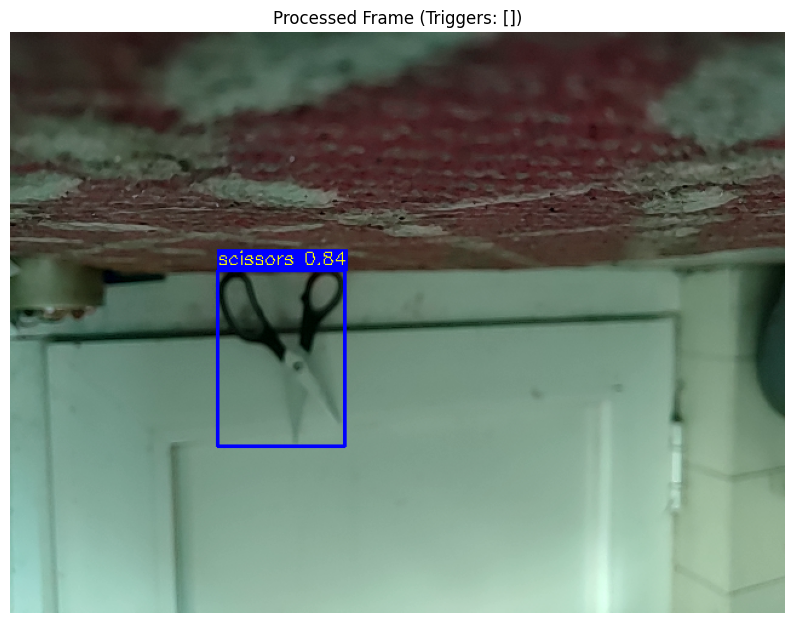


Detections:
1. scissors: 0.84
Processed frame 1
Detected 1 objects, 0 triggers: []
Detected 1 objects, 0 triggers: []


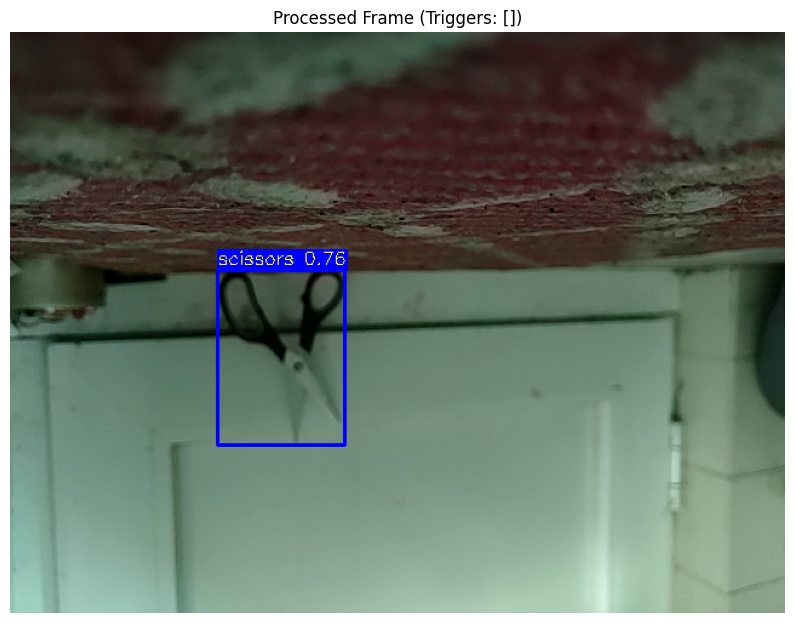


Detections:
1. scissors: 0.76
Processed frame 2
Detected 1 objects, 0 triggers: []
Detected 1 objects, 0 triggers: []


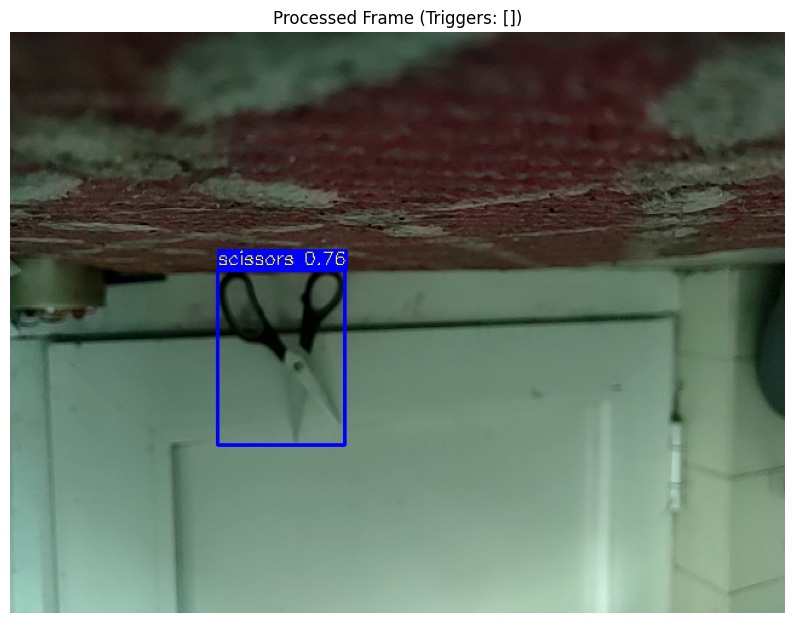


Detections:
1. scissors: 0.76
Processed frame 3
Pipeline stopped
[SIMULATED] GPIO resources cleaned up
Frame processing pipeline stopped
Pipeline completed after processing 3 frames
Pipeline stopped
[SIMULATED] GPIO resources cleaned up
Frame processing pipeline stopped
Pipeline completed after processing 3 frames


In [31]:
class FrameProcessingPipeline:
    """Complete frame processing pipeline for both Windows and Linux"""
    
    def __init__(self, use_test_images=True, camera_id=0):
        """
        Initialize the frame processing pipeline
        
        Args:
            use_test_images: If True, use test images instead of GStreamer
            camera_id: Camera ID for GStreamer (0 for CSI0, 1 for CSI1)
        """
        self.use_test_images = use_test_images
        self.camera_id = camera_id
        self.running = False
        self.frame_delay = 1.0  # Seconds between frames
        
        # Platform detection
        self.is_windows = sys.platform == 'win32'
        self.is_qualcomm = not self.is_windows
        
        # Force test images on Windows
        if self.is_windows:
            self.use_test_images = True
        
        # Initialize components
        self.frame_source = None
        self.detector = ObjectDetector(confidence_threshold=0.5)
        self.gpio = GPIOController(simulate=self.is_windows)
        
        # Debug options
        self.show_all_detections = True
        self.show_labels = True
        self.display_output = True
        
        # Set up GPIO pins for triggers
        self.gpio.setup_pin("squirrel", 17)
        self.gpio.setup_pin("bird", 18)
        self.gpio.setup_pin("animal", 27)
        self.gpio.setup_pin("cat", 22)
        self.gpio.setup_pin("dog", 23)
        
        # Configure the detector's debug options
        self.detector.set_debug_options(
            show_all_detections=self.show_all_detections,
            show_labels=self.show_labels
        )
        
        # Initialize frame source based on platform and settings
        self._initialize_frame_source()
    
    def _initialize_frame_source(self):
        """Initialize the appropriate frame source"""
        if self.use_test_images:
            # Use test images
            self.frame_source = TestImageProcessor()
            # Create sample images if none exist
            self.frame_source.add_sample_images()
        else:
            # Use GStreamer (not on Windows)
            if self.is_windows:
                print("GStreamer capture not supported on Windows, falling back to test images")
                self.use_test_images = True
                self.frame_source = TestImageProcessor()
                self.frame_source.add_sample_images()
            else:
                # We're on Linux/Qualcomm, use GStreamer with CSI camera
                self.frame_source = FrameCapture()
    
    def set_debug_options(self, show_all_detections=None, show_labels=None, display_output=None):
        """Set debug options for the pipeline"""
        if show_all_detections is not None:
            self.show_all_detections = show_all_detections
            self.detector.set_debug_options(show_all_detections=self.show_all_detections)
        
        if show_labels is not None:
            self.show_labels = show_labels
            self.detector.set_debug_options(show_labels=self.show_labels)
            
        if display_output is not None:
            self.display_output = display_output
    
    def start(self):
        """Start the frame processing pipeline"""
        self.running = True
        
        # Start the frame source if it's a GStreamer capture
        if not self.use_test_images and isinstance(self.frame_source, FrameCapture):
            self.frame_source.start()
            # Give it time to initialize
            time.sleep(2)
        
        print("Frame processing pipeline started")
    
    def stop(self):
        """Stop the frame processing pipeline"""
        self.running = False
        
        # Stop the frame source if it's a GStreamer capture
        if not self.use_test_images and isinstance(self.frame_source, FrameCapture):
            self.frame_source.stop()
        
        # Clean up GPIO
        self.gpio.cleanup()
        
        print("Frame processing pipeline stopped")
    
    def process_single_frame(self):
        """Process a single frame"""
        # Get frame from appropriate source
        if self.use_test_images:
            frame = self.frame_source.get_next_frame()
        else:
            frame = self.frame_source.get_frame()
        
        if frame is None:
            print("Failed to get frame")
            return None
        
        # Detect objects
        processed_frame, detections, triggers = self.detector.detect(frame)
        
        # Trigger GPIO pins for detected objects
        if triggers:
            self.gpio.process_triggers(triggers)
        
        # Display the processed frame if needed
        if self.display_output:
            plt.figure(figsize=(10, 8))
            plt.imshow(processed_frame)
            plt.title(f"Processed Frame (Triggers: {triggers})")
            plt.axis('off')
            plt.show()
            
            # Print detection details
            if detections:
                print("\nDetections:")
                for i, det in enumerate(detections):
                    confidence = det['confidence']
                    class_name = det['class_name']
                    confidence_str = f"{confidence:.2f}"
                    is_trigger = class_name in triggers
                    trigger_str = " (TRIGGER)" if is_trigger else ""
                    print(f"{i+1}. {class_name}: {confidence_str}{trigger_str}")
            else:
                print("No objects detected")
        
        return processed_frame, detections, triggers
    
    def run(self, num_frames=5):
        """
        Run the pipeline for a specified number of frames
        
        Args:
            num_frames: Number of frames to process (None for infinite)
        """
        self.start()
        
        frame_count = 0
        try:
            while self.running:
                # Process a frame
                result = self.process_single_frame()
                
                if result is None:
                    print("Error processing frame")
                    break
                
                frame_count += 1
                print(f"Processed frame {frame_count}")
                
                # Check if we've reached the desired number of frames
                if num_frames is not None and frame_count >= num_frames:
                    break
                
                # Wait between frames
                time.sleep(self.frame_delay)
                
        except KeyboardInterrupt:
            print("Pipeline interrupted by user")
        finally:
            self.stop()
            
        print(f"Pipeline completed after processing {frame_count} frames")

# Create and run the pipeline
# On Windows, this will automatically use test images
# On Linux, it will use the CSI camera via GStreamer
pipeline = FrameProcessingPipeline(use_test_images=(sys.platform == 'win32'), camera_id=0)

# Set debug options
pipeline.set_debug_options(
    show_all_detections=True,  # Show all detections, not just those that trigger
    show_labels=True,          # Show class labels and confidence values
    display_output=True        # Display frames (set to False for headless operation)
)

# Run the pipeline for 3 frames (reduce this for faster execution)
pipeline.run(num_frames=3)

## 15. Conclusion and Next Steps

This notebook has demonstrated a complete pipeline for:

1. **Frame Capture**: Using test images on Windows and GStreamer on Linux (Qualcomm QCM6490)
2. **Object Detection**: Using QAI Hub's YOLOv11 model to detect objects
3. **Trigger Actions**: Activating GPIO pins when specific objects are detected
4. **Debug Visualization**: Displaying processed frames with detection boxes and labels

### To deploy this on your Qualcomm QCM6490 device:

1. Transfer this notebook to your device
2. Install the necessary dependencies:
   ```
   pip install qai-hub-models[yolov11-det] opencv-python numpy matplotlib
   sudo apt-get install -y gstreamer1.0-plugins-base gstreamer1.0-plugins-good gstreamer1.0-plugins-bad gstreamer1.0-plugins-ugly python3-gi python3-gst-1.0 python3-rpi.gpio
   ```
3. Update the GPIO pins according to your device's pin mappings
4. Set `use_test_images=False` when creating the `FrameProcessingPipeline` to use the CSI camera
5. For headless operation, set `display_output=False` in the debug options

### Customization Options:

1. **Target Classes**: Modify `target_classes` in the `ObjectDetector` class to focus on specific objects
2. **Confidence Threshold**: Adjust `confidence_threshold` to change detection sensitivity
3. **GPIO Mappings**: Map different detected objects to different GPIO pins
4. **CSI Camera Selection**: Use `camera_id=0` for CSI0 or `camera_id=1` for CSI1

### Performance Considerations:

For better performance on the Qualcomm device, consider:
1. Using hardware-accelerated elements in the GStreamer pipeline
2. Reducing frame resolution if full HD (1920x1080) is not needed
3. Optimizing the model with QAI Hub's quantization options